In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tweunseo","key":"44c4eebefba7ecc9f7aba485dc5d39b6"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets list -s xray

ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
bachrr/covid-chest-xray                                         COVID-19 chest xray                                  252641948  2020-05-15 00:30:50.877000          14121        252  0.9411765        
nikhilpandey360/chest-xray-masks-and-labels                     Chest Xray Masks and Labels                        10281955076  2019-01-21 09:11:43.557000          23545        210  0.75             
khoongweihao/covid19-xray-dataset-train-test-sets               COVID-19 Xray Dataset (Train & Test Sets)             88399353  2020-03-19 01:49:56.503000          13565        198  0.875            


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:31<00:00, 103MB/s] 
100% 2.29G/2.29G [00:31<00:00, 78.0MB/s]


In [5]:
!unzip chest-xray-pneumonia.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/tra

In [6]:
!ls /content

chest_xray  chest-xray-pneumonia.zip  kaggle.json  sample_data


In [7]:
import torch
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

image_size = 224
batch_size = 16

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(image_size, scale=(0.9, 1.0)),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

train_dir = "/content/chest_xray/train"
val_dir = "/content/chest_xray/val"
test_dir = "/content/chest_xray/test"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# DataLoader (batch_size=16)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [9]:
import torch.nn as nn
import torchvision.models as models

model = models.densenet121(weights="IMAGENET1K_V1")
model.classifier = nn.Linear(model.classifier.in_features, 1)  # 1채널 로짓 출력

model = model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 188MB/s]


In [10]:
from torch.optim import Adam

loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [11]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. 정확도 및 손실 기록 리스트 초기화
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 2. 정확도 계산 함수 정의
def calculate_accuracy(loader, model, device):
    """주어진 DataLoader와 모델에 대한 정확도를 계산합니다."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs).squeeze(1)

            preds = (torch.sigmoid(outputs) > 0.5).long()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [12]:
num_epochs = 20
best_val_loss = float("inf")
best_model_path = "best_densenet121.pth"

for epoch in range(num_epochs):
    ###################################################
    # TRAIN
    ###################################################
    model.train()
    train_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.float().to(device)

        optimizer.zero_grad()

        outputs = model(imgs).squeeze(1)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # 훈련 정확도 계산 및 기록
    train_acc = calculate_accuracy(train_loader, model, device)

    train_accuracies.append(train_acc)
    train_losses.append(train_loss)

    ###################################################
    # VALIDATION
    ###################################################
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.float().to(device)

            outputs = model(imgs).squeeze(1)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item()

    val_loss /= len(val_loader)

    # 검증 정확도 계산 및 기록
    val_acc = calculate_accuracy(val_loader, model, device)

    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
    print(f"[Epoch {epoch+1}/{num_epochs}] Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    # Best epoch 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(" → Best model saved!")

print("Training Complete!")

[Epoch 1/20] Train Acc: 0.9841 | Train Loss: 0.1457 | Val Acc: 0.8750 | Val Loss: 0.2582
 → Best model saved!
[Epoch 2/20] Train Acc: 0.9877 | Train Loss: 0.0893 | Val Acc: 0.8750 | Val Loss: 0.3337
[Epoch 3/20] Train Acc: 0.9766 | Train Loss: 0.0669 | Val Acc: 0.9375 | Val Loss: 0.1575
 → Best model saved!
[Epoch 4/20] Train Acc: 0.9858 | Train Loss: 0.0482 | Val Acc: 0.9375 | Val Loss: 0.1369
 → Best model saved!
[Epoch 5/20] Train Acc: 0.9839 | Train Loss: 0.0414 | Val Acc: 0.6250 | Val Loss: 0.5123
[Epoch 6/20] Train Acc: 0.9921 | Train Loss: 0.0412 | Val Acc: 0.9375 | Val Loss: 0.1112
 → Best model saved!
[Epoch 7/20] Train Acc: 0.9956 | Train Loss: 0.0352 | Val Acc: 1.0000 | Val Loss: 0.1124
[Epoch 8/20] Train Acc: 0.9941 | Train Loss: 0.0267 | Val Acc: 0.7500 | Val Loss: 0.4208
[Epoch 9/20] Train Acc: 0.9941 | Train Loss: 0.0294 | Val Acc: 0.8750 | Val Loss: 0.2785
[Epoch 10/20] Train Acc: 0.9954 | Train Loss: 0.0290 | Val Acc: 0.6875 | Val Loss: 0.5415
[Epoch 11/20] Train Acc: 

In [13]:
# best 모델 로드
model.load_state_dict(torch.load(best_model_path))
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs).squeeze(1)
        preds = torch.sigmoid(outputs) > 0.5

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"📌 Test Accuracy: {test_acc * 100:.2f}%")

📌 Test Accuracy: 94.71%


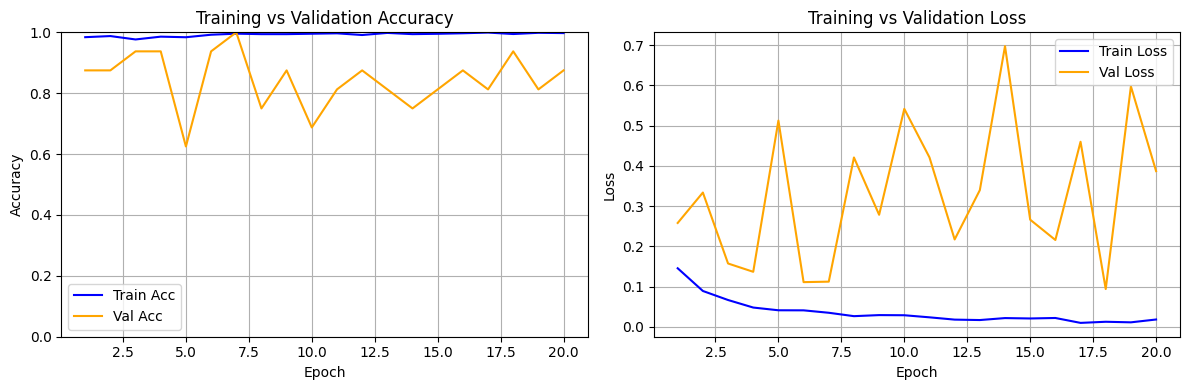

In [14]:
import matplotlib.pyplot as plt

model_name = "DenseNet-121"

epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(12, 4))

# 1. Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, color="blue", label="Train Acc")
plt.plot(epochs, val_accuracies, color="orange", label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()

# 2. Loss Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, color="blue", label="Train Loss")
plt.plot(epochs, val_losses, color="orange", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

Confusion Matrix:
[[208  26]
 [  7 383]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.89      0.93       234
   PNEUMONIA       0.94      0.98      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.94      0.94       624
weighted avg       0.95      0.95      0.95       624



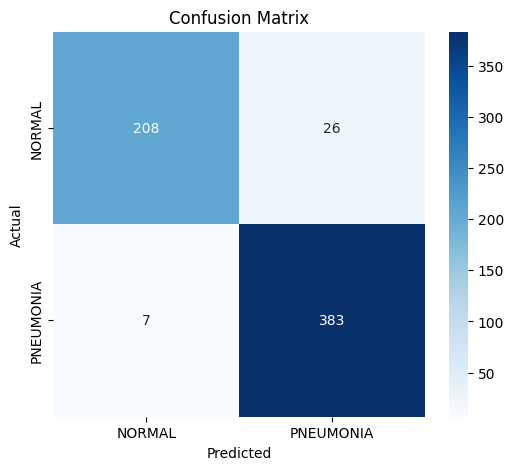

In [15]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 로드 후 평가 모드라고 가정
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).long()   # 정답 라벨 long

        outputs = model(imgs).squeeze(1)
        preds = (torch.sigmoid(outputs) > 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# -------------------------------
# 1) Confusion Matrix 계산
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)

# -------------------------------
# 2) Classification Report (Accuracy, Precision, Recall, F1)
# -------------------------------
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["NORMAL", "PNEUMONIA"]))

# -------------------------------
# 3) Confusion Matrix 시각화
# -------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

NORMAL example index : 0
PNEUMONIA example index : 234

--- Index 0 | True Label: NORMAL ---


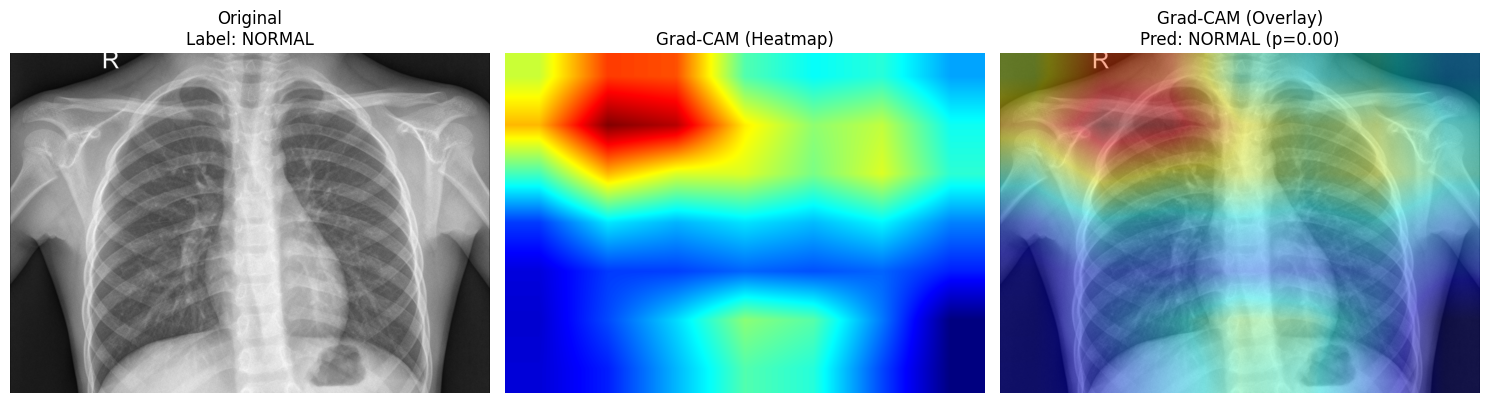

Model Predicted: NORMAL

--- Index 234 | True Label: PNEUMONIA ---


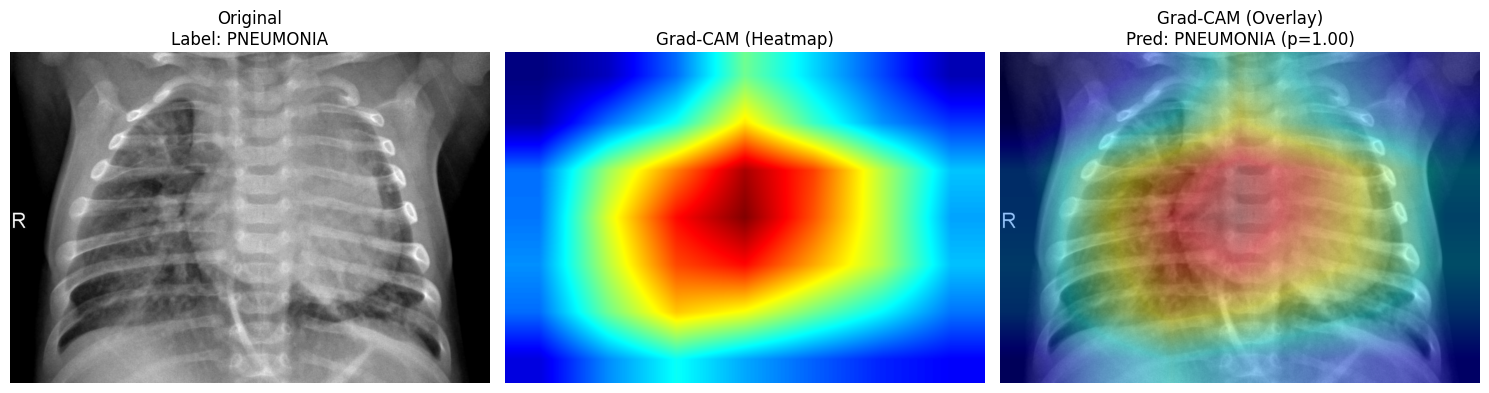

Model Predicted: PNEUMONIA


In [19]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1) Grad-CAM 클래스
# ------------------------------------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None


        self.target_layer.register_forward_hook(self._save_activation)

        self.target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self):
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        for i in range(activations.shape[0]):
            activations[i] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) + 1e-10
        return heatmap


# ------------------------------------------------------
# 2) 이미지 전처리
# ------------------------------------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    tensor = preprocess(img).unsqueeze(0)
    return img, tensor


# ------------------------------------------------------
# 3) Grad-CAM 실행 함수
# ------------------------------------------------------
def apply_gradcam(model, image_path, device, true_class):
    model = model.to(device)
    model.eval()

    target_layer = model.features
    cam = GradCAM(model, target_layer)

    img_pil, img_tensor = load_image(image_path)
    img_tensor = img_tensor.to(device)
    img_tensor.requires_grad = True

    output = model(img_tensor)

    prob = torch.sigmoid(output).item()
    pred = 1 if prob > 0.5 else 0

    model.zero_grad()
    grad_target = torch.ones_like(output) if pred == 1 else -torch.ones_like(output)
    output.backward(grad_target)

    heatmap = cam.generate()

    img_np = np.array(img_pil)
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_color = cv2.applyColorMap(
        np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET
    )
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = (0.6 * img_np + 0.4 * heatmap_color).astype(np.uint8)

    prob_text = f"(p={prob:.2f})"

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title(f"Original\nLabel: {true_class}")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM (Heatmap)")
    plt.imshow(heatmap_color)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Grad-CAM (Overlay)\nPred: {class_names[pred]} {prob_text}")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return class_names[pred]


# ------------------------------------------------------
# 4) 시각화 실행 함수
# ------------------------------------------------------
def visualize_prediction(model, dataset, index, device, class_names):
    image_path, true_label = dataset.samples[index]
    true_class = class_names[true_label]

    print(f"\n--- Index {index} | True Label: {true_class} ---")

    pred_name = apply_gradcam(model, image_path, device, true_class)

    print(f"Model Predicted: {pred_name}")


# ------------------------------------------------------
# 5) 실행 부분
# ------------------------------------------------------
class_names = ["NORMAL", "PNEUMONIA"]

targets = test_dataset.targets
idx_normal = next(i for i, t in enumerate(targets) if t == 0)
idx_pneu   = next(i for i, t in enumerate(targets) if t == 1)

print("NORMAL example index :", idx_normal)
print("PNEUMONIA example index :", idx_pneu)

visualize_prediction(model, test_dataset, idx_normal, device, class_names)
visualize_prediction(model, test_dataset, idx_pneu, device, class_names)